# 0. Imports

Loading the necessary libraries we'll need for our project, and the dataset we're working on.

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import sklearn

In [2]:
df = pd.read_csv("./playground-series-s4e9/train.csv",index_col='id')
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


# 1. Column Transformations

After reviewing the dataset, we decided to apply several transformations to the attributes in order to prepare the data for later use in a linear regression model.

## 1.1 Engine Transformer

The original `engine` attribute was a string containing the **horse power**, **number of cylinders**, and **tank size** in liters. Since this information is crucial for our analysis, we extracted these three features using regex (as the string followed a specific format) and created separate numerical columns for each.  
Afterward, the original `engine` attribute was dropped, as it was no longer needed.

In [3]:
def EngineTransformer(X):
	X = X.copy()

	# In case the engine column did not contain the string
	# X['horse_power'] = -1
	# X['tank_size'] = -1
	# X['num_cylinders'] = -1

	X['horse_power'] = X['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
	X['tank_size'] = X['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
	X['num_cylinders'] = X['engine'].str.extract(r'(\d+)\sCylinder').astype(float) 
	   
	# Drop the original 'engine' column
	X.drop('engine', axis=1, inplace=True)
	return X

## 1.2 Transmission Transformer
The `transmission` attribute contained an unformatted string. We used regex to identify the relevant keywords and created three binary columns: `automatic`, `dual`, and `manual`.  
Each car can have only one of these attributes set to `True`.  
We decided to separate the `dual` category instead of marking both `automatic` and `manual` as `True` because it might carry unique signals that we want to capture.


In [4]:
def TransmissionTransformer(X):
	# Initialize all attributes to False
    X = X.copy()

    X['automatic'] = False
    X['manual'] = False
    X['dual'] = False
    
    # Categorize as 'dual' if it contains 'Dual'
    X.loc[X['transmission'].str.contains(r'\b(Dual|At/Mt)\b', case=False, na=False), 'dual'] = True
    
    # Ensure 'dual' is boolean before using ~ operator
    X['dual'] = X['dual'].astype(bool)
    # Categorize as 'automatic' if it contains AT, A/T, CVT, or Automatic (but not Dual)
    X.loc[(X['transmission'].str.contains(r'\b(AT|A/T|CVT|Automatic)\b', case=False, na=False)) & ~X['dual'], 'automatic'] = True
    # Categorize as 'manual' if it contains MT, M/T, or Manual (but not Dual)
    X.loc[(X['transmission'].str.contains(r'\b(MT|M/T|Manual)\b', case=False, na=False)) & ~X['dual'], 'manual'] = True

    # Drop the original 'transmission' column
    X.drop('transmission', axis=1, inplace=True)
    
    return X

## 1.3 Color Transformer
We analyzed the `int_color` and `ext_color` attributes and decided to keep only the top 12 colors (based on value counts). The remaining colors were grouped into an "other" category.  
This way, we can maintain a reasonable number of color categories and transform them into a one-hot encoded vector.

In [5]:
def ColorTransformer(X):
	X = X.copy()
	# Colors to keep (top 12)
	ext_colors = list(df["ext_col"].value_counts()[:12].index)
	int_colors = list(df["int_col"].value_counts()[:12].index)
	int_colors.remove("–")
	# Categorize as 'other' if not in the top 12 colors
	X.loc[~X['ext_col'].isin(ext_colors), 'ext_col'] = 'other'
	X.loc[~X['int_col'].isin(int_colors), 'int_col'] = 'other'
	
	return X

## 1.4 Brand Transformer
Similarly to the `color` attribute, we applied the same approach to the `brand` column, but this time we kept the top 24 brands due to their potential significance. Brands outside the top 24 were grouped into an "other" category.

In [6]:
def BrandTransformer(X):
	X = X.copy()
	# Brands to keep (top 24)
	brands = list(df["brand"].value_counts()[:24].index)
	# Categorize as 'other' if not in the top 24 brands
	X.loc[~X['brand'].isin(brands), 'brand'] = 'other'
	
	return X

## 1.5 Clean Title Transformer
For the `clean_title` attribute, we replaced the string "Yes" with a boolean `True`, simplifying the column for modeling purposes.

In [7]:
def CleanTitleTransformer(X):
    X = X.copy()
    # Change the "Yes" to the boolean True
    X['clean_title'] = X['clean_title'].replace('Yes', True)
    
    return X

## 1.6 Accident Transformer
The `accident` attribute contained string values such as "None reported" and "At least 1 accident or damage reported."  
We transformed these into boolean values, setting "None reported" to `True` and "At least 1 accident or damage reported" to `False`.

In [8]:
def AccidentTransformer(X):
	X = X.copy()
	# Change the "None reported" to the boolean True and At least 1 accident or damage reported to False
	X['accident'] = X['accident'].replace('None reported', False)
	X['accident'] = X['accident'].replace('At least 1 accident or damage reported', True)
	
	return X

The Column Organizer function is for making sure the target column is at the rightmost.

In [9]:
def ColumnOrganizer(X):
	X = X.copy()
	X = X.drop(columns=['model'])

	# Move the target column to the end, in case X is the test set there is no target column
	cols = X.columns.tolist()
	if "price" in cols:
		cols.append(cols.pop(cols.index('price')))
		X = X[cols]

	return X

This is the final function that applies all the transformers on the dataset to create the necessary effects.

In [10]:
def columnTransformer(X):
    X = EngineTransformer(X)
    X = TransmissionTransformer(X)
    X = ColorTransformer(X)
    X = BrandTransformer(X)
    X = CleanTitleTransformer(X)
    X = AccidentTransformer(X)
    X = ColumnOrganizer(X)
    
    return X

# 2. Filling Null Values

### Strategies

Since the number of NUlls is very low (3%, 1.5% of the data respectively) we have 2 options:

- Strategy 1 - dropping those entries and train the model without them.

- Strategy 2 - Replacing them with another value:
1. **fuel_type** - Gasoline, because it is by far the most common option in the train dataset.
2. **accident** - False, Assuming if no accident was mentioned, then there was no accident.
3. **clean_title** - Likewise.
4. **horse_power** - The average horse power in the train dataset, rounded to the nearest integer.
5. **tank_size** - Likewise.
6. **num_cylinders** - Likewise.

We chose strategy 2 to preserve this data.

In [11]:
def Imputer(X):
	X = X.copy()
	
	X["fuel_type"] = X["fuel_type"].replace('not supported', "Gasoline")
	X["fuel_type"] = X["fuel_type"].replace('–', "Gasoline")
	X["fuel_type"] = X["fuel_type"].replace(pd.NA, "Gasoline")

	X['accident'] = X['accident'].fillna(False)

	X['clean_title'] = X['clean_title'].fillna(False)

	# need to be changed into the mean of the training set, because when we are predicting the test set, we don't want to use the test set mean
	X['horse_power'] = X['horse_power'].fillna(round(X['horse_power'].mean()))

	X['tank_size'] = X['tank_size'].fillna(round(X['tank_size'].mean()))

	X['num_cylinders'] = X['num_cylinders'].fillna(round(X['num_cylinders'].mean()))
	
	return X

In [12]:
def preprocessor(X):
	X = columnTransformer(X)
	X = Imputer(X)
	
	return(X)

# I. Applying the Preprocessing steps

In [13]:
df_preprocessed = preprocessor(df)

C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_30308\771887330.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[X['transmission'].str.contains(r'\b(Dual|At/Mt)\b', case=False, na=False), 'dual'] = True
C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_30308\771887330.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[(X['transmission'].str.contains(r'\b(AT|A/T|CVT|Automatic)\b', case=False, na=False)) & ~X['dual'], 'automatic'] = True
C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_30308\771887330.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[(X['transmission'].str.contains(r'\b(MT|M/T|Manual)\b', case=False, na=False)) & ~X['dual'], 'manual'] = True
C:\Users\Yael Dahari\AppData\Local\Tem

In [14]:
df_preprocessed.head()

,brand,model_year,milage,fuel_type,ext_col,int_col,accident,clean_title,horse_power,tank_size,num_cylinders,automatic,manual,dual,price
id,,,,,,,,,,,,,,,
0,other,2007,213000,Gasoline,Yellow,Gray,False,True,172.0,1.6,4.0,True,False,False,4200
1,Lincoln,2002,143250,Gasoline,Silver,Beige,True,True,252.0,3.9,8.0,True,False,False,4999
2,Chevrolet,2002,136731,E85 Flex Fuel,Blue,Gray,False,True,320.0,5.3,8.0,True,False,False,13900
3,other,2017,19500,Gasoline,Black,Black,False,True,420.0,5.0,8.0,False,False,True,45000
4,Mercedes-Benz,2021,7388,Gasoline,Black,Beige,False,True,208.0,2.0,4.0,True,False,False,97500


In [15]:
df_preprocessed.dtypes

brand             object
model_year         int64
milage             int64
fuel_type         object
ext_col           object
int_col           object
accident            bool
clean_title         bool
horse_power      float64
tank_size        float64
num_cylinders    float64
automatic           bool
manual              bool
dual                bool
price              int64
dtype: object

In [16]:
df_preprocessed.isna().sum()

brand            0
model_year       0
milage           0
fuel_type        0
ext_col          0
int_col          0
accident         0
clean_title      0
horse_power      0
tank_size        0
num_cylinders    0
automatic        0
manual           0
dual             0
price            0
dtype: int64

# 3. Visualizing Relationships Between Attributes and Price

In this presentation, we aim to explore five compelling visualizations that uncover interesting relationships between various car attributes and their impact on price. By analyzing these connections, we seek to gain deeper insights into how factors such as engine characteristics, fuel type, and brand influence a car's market value. These visualizations are designed to highlight patterns, trends, and potential correlations, providing valuable perspectives on the dataset and its attributes.

### 3.1 Engine Attributes vs. Price

This visualization highlights the relationship between three key engine attributes—horsepower, number of cylinders, and fuel tank size—and their impact on a car's price.

By transforming the price to a logarithmic scale, we account for the skewness in the distribution, allowing for a clearer analysis of trends across different price ranges.

Conclusions:

- From this plot, we observe that as horsepower and the number of cylinders increase, the price tends to rise as well, indicating that more powerful or complex engines generally correlate with higher-priced vehicles.

- However, we notice that the fuel tank size does not show a clear correlation with price. This suggests that while engine performance (horsepower and cylinders) plays a significant role in determining price, the fuel tank size might not be a major factor.


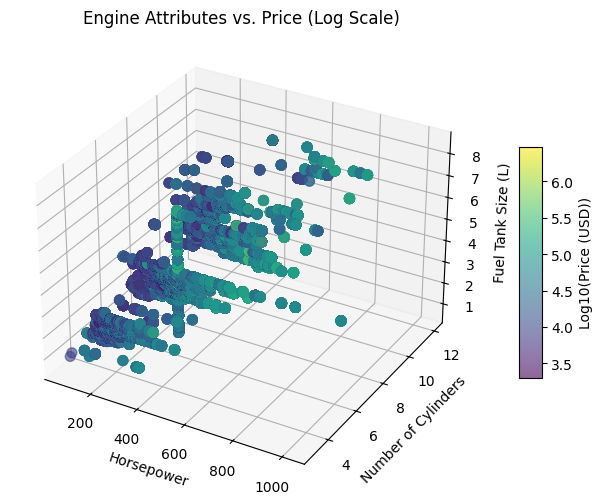

In [17]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

prices_log = np.log10(df_preprocessed['price'])

# Scatter plot
sc = ax.scatter(df_preprocessed['horse_power'], df_preprocessed['num_cylinders'],
				df_preprocessed['tank_size'], c=prices_log,
				cmap='viridis', s=50, alpha=0.6)

# Add labels and title
ax.set_title('Engine Attributes vs. Price (Log Scale)')
ax.set_xlabel('Horsepower')
ax.set_ylabel('Number of Cylinders')
ax.set_zlabel('Fuel Tank Size (L)')

# Add a color bar to represent the price
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Log10(Price (USD))')

plt.show()


### 3.2 Correlation Heatmap Between All Numerical Attributes

This heatmap provides a visual representation of the correlation between the numerical attributes in our dataset. It is particularly useful for identifying relationships that might not be immediately obvious, allowing us to focus on key variables that influence the price.

We can observe several interesting trends:

- **Model year and mileage** are strongly negatively correlated, which makes sense as newer cars generally have fewer miles driven. This is a typical pattern in used car datasets.

- **Tank size and number of cylinders** exhibit a very strong positive correlation. This suggests that cars with larger engines (more cylinders) tend to have bigger fuel tanks, which is an expected relationship given the design of larger vehicles.

- **Horsepower and number of cylinders** also show a positive correlation, reflecting the fact that cars with more cylinders generally have greater horsepower.

The attributes with the **highest correlation** to price are:

- **Mileage** (-0.28): The negative correlation indicates that as mileage increases, the price tends to decrease, which is a common observation for used cars.

- **Model year** (0.23): A positive correlation with price is expected, as newer models generally command higher prices.


Understanding these correlations is key to forming insights about which features are most important in determining the car's price. This can guide further analysis, including predictive modeling or targeted marketing strategies.

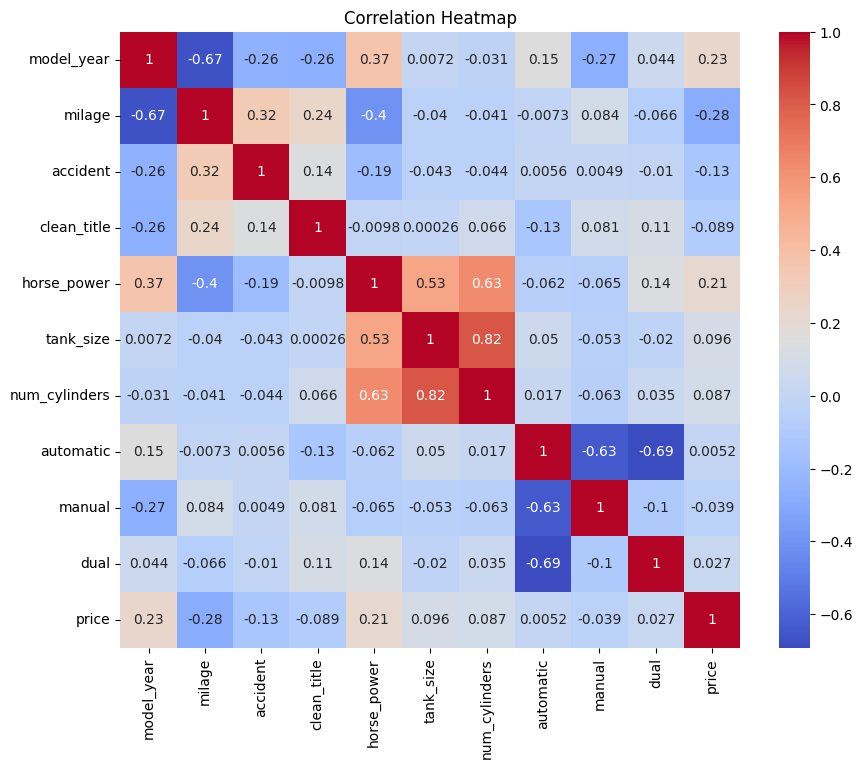

In [18]:
fig, ax = plt.subplots(figsize=(10,8))

numerical_cols = df_preprocessed.dtypes[(df_preprocessed.dtypes=="float64") | (df_preprocessed.dtypes=="int64") | (df_preprocessed.dtypes=="bool")].index.tolist()

corr_matrix = df_preprocessed[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.title('Correlation Heatmap')
plt.show()

### 3.3 Average Price by Fuel Type and Brand

This bar chart visualizes the average price of cars based on fuel type and brand. A few interesting trends can be observed:

- **E85 Flex Fuel** has the lowest average prices across almost all brands. However, **Kia** stands out as an exception, with **E85 Flex Fuel** having the highest average price among all fuel types in the dataset.

- **Porsche** and **Mercedes-Benz** consistently show high average prices across the fuel types of **Gasoline**, **Hybrid**, and **Plug-In Hybrid**, which aligns with their status as luxury brands known for higher-priced vehicles.

- **Cadillac** and **Jeep** have particularly high average prices for the **Diesel** fuel type, which could be due to the types of vehicles (e.g., SUVs, trucks) they tend to produce, often at higher price points.

- **Tesla** does not exhibit a distinctly higher average price in any of the fuel types, which may be surprising given its premium electric vehicles. This suggests that Tesla’s pricing is not as dependent on fuel type but may be influenced by other factors.

- **Acura**, **Hyundai**, **Nissan**, **Mazda**, and **Subaru** are missing from several fuel types, which may indicate a limited variety of vehicles within those fuel types. This could impact the model’s ability to make accurate price predictions for these brands in specific fuel categories.

This graph is useful for understanding how the combination of fuel type and brand impacts the price of a car. By examining these trends, we can infer which brands tend to have higher or lower prices for specific fuel types and assess how well a model might predict car prices based on these factors.

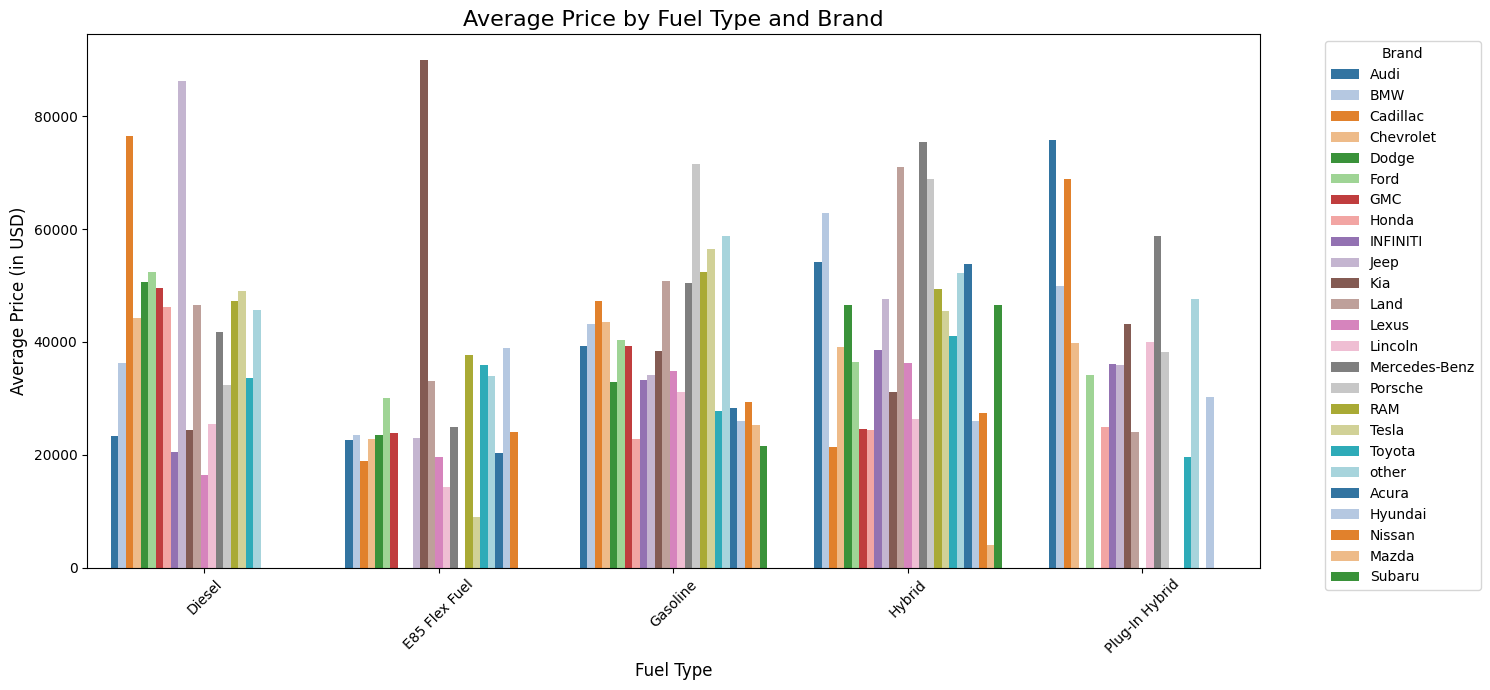

In [62]:
# Compute the average price grouped by fuel type and brand
avg_price_by_fuel_and_brand = (
    df_preprocessed.groupby(['fuel_type', 'brand'])['price']
    .mean()
    .reset_index()
)

# Set up the plot
fig, ax = plt.subplots(figsize=(15, 7))

# Create a grouped bar chart
sns.barplot(
    data=avg_price_by_fuel_and_brand, 
    x='fuel_type', 
    y='price', 
    hue='brand', 
    ax=ax, 
    palette='tab20'
)

# Add title and labels
plt.title('Average Price by Fuel Type and Brand', fontsize=16)
plt.xlabel('Fuel Type', fontsize=12)
plt.ylabel('Average Price (in USD)', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.tight_layout()

# Show the plot
plt.show()


### 3.4 Average Price by Brand and by Accident History or Clean Title

The heatmaps provide insights into how **accident history** and **clean title** status impact the average price of cars across different brands:

- **Accident History**: As expected, cars that have not been in an accident generally command higher prices compared to those that have been involved in accidents. This aligns with the assumption that accident-free cars are typically in better condition and more desirable on the market.

- **Clean Title**: Surprisingly, cars without a clean title consistently show higher average prices than those with a clean title. This is counterintuitive, as cars with a clean title are usually perceived as more reliable and have higher resale value. This anomaly suggests that there might be an issue with how the clean title attribute is represented in the dataset. It could indicate missing or inconsistent data, which could affect the accuracy of the model's predictions.

Given this inconsistency, further investigation into the dataset is necessary. The model's performance may be impacted by this feature, and we may need to reconsider its inclusion in the analysis or apply an imputation technique to handle missing or anomalous values.

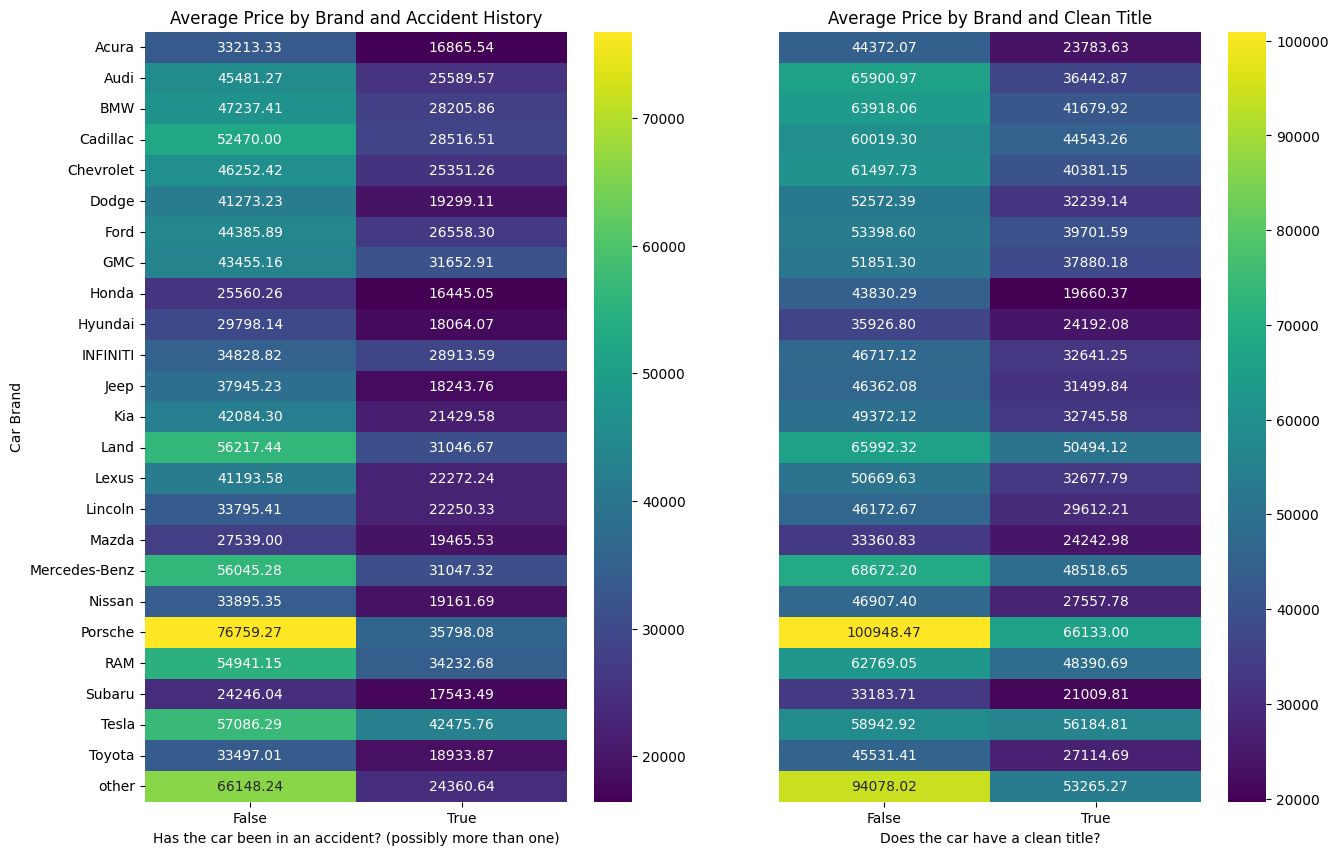

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))

# The first is the y axis, the second is the x axis
avg_price_by_brand_accident = df_preprocessed.groupby(['brand', 'accident'])['price'].mean().unstack()
heatmap1 = sns.heatmap(avg_price_by_brand_accident, annot=True, fmt=".2f", cmap='viridis', ax=ax[0], cbar = True)
ax[0].set_title('Average Price by Brand and Accident History')
ax[0].set_xlabel('Has the car been in an accident? (possibly more than one)')
ax[0].set_ylabel('Car Brand')

# Remove when imputer is used
# df_clean = df_preprocessed.copy()
# df_clean['clean_title'] = df_clean['clean_title'].fillna(False)

avg_price_by_brand_clean = df_preprocessed.groupby(['brand', 'clean_title'])['price'].mean().unstack()
heatmap2 = sns.heatmap(avg_price_by_brand_clean, annot=True, fmt=".2f", cmap='viridis', ax=ax[1], cbar = True)
ax[1].set_title('Average Price by Brand and Clean Title')
ax[1].set_xlabel('Does the car have a clean title?')
ax[1].set_ylabel('')
ax[1].set_yticks([])

plt.show()

### 3.5 Distribution of Car Prices by Model Year Intervals (Logarithmic Scale)

In this analysis, the car model years are grouped into 5-year intervals, and the distribution of car prices within each interval is visualized using a box plot. The prices are transformed to a logarithmic scale for better comparison across a wide range of values.

Key Observations:
- **1973-1979**: Surprisingly, the median price in this interval is relatively high, which is counterintuitive since older cars are typically expected to have lower prices. This anomaly might indicate the presence of collectible or rare cars from this period, or potentially some outliers that skew the median.

- **Price Trend by Year**: As expected, newer cars (from 1990 onwards) generally have higher median prices, reflecting the increased desirability of newer models due to advancements in technology, features, and overall condition.

- **Inter-Quartile Range**: The distance between the quantiles remains relatively consistent across the intervals, suggesting that the spread of prices within each period is similar. This indicates that the market dynamics and price variations within these intervals have remained relatively stable, with some slight increases in variability as we move toward more recent years.

- **Outliers between 1990 and 2004**: In this period, most of the outliers appear above the maximum value of the box plot, indicating that there are a significant number of cars that are priced much higher than the typical price range for cars in this interval. This could be due to high-end, luxury, or premium cars that stand out in terms of price, with very few cars breaking the upper price boundary of the box plot.

- **Outliers from 2005 onward**: Starting from 2005, while we still observe outliers above the maximum price of the box plot, there is a notable increase in outliers that fall below the minimum price of the box plot. These "smaller" outliers could indicate:

    - A rise in lower-priced cars entering the market, possibly due to more affordable, economy models becoming prevalent.
    - A broader range of vehicle prices, reflecting greater diversity in the car market, with some cars being significantly cheaper (e.g., due to condition, brand value, or used car pricing) while others remain at the higher end of the spectrum.

**Conclusion**:
The box plot analysis reveals several trends in car pricing over time, with some surprising exceptions, particularly in the older car models. The overall upward price trend is consistent with the expectation that newer cars tend to be more expensive. The increase in outliers and slight widening of price distributions from 2005 onwards suggests a growing diversity in the market for cars, possibly due to the rise of new models, electric vehicles, or changing consumer preferences. The consistent inter-quartile range implies that, while prices may fluctuate, the distribution of car prices has remained relatively stable over time.

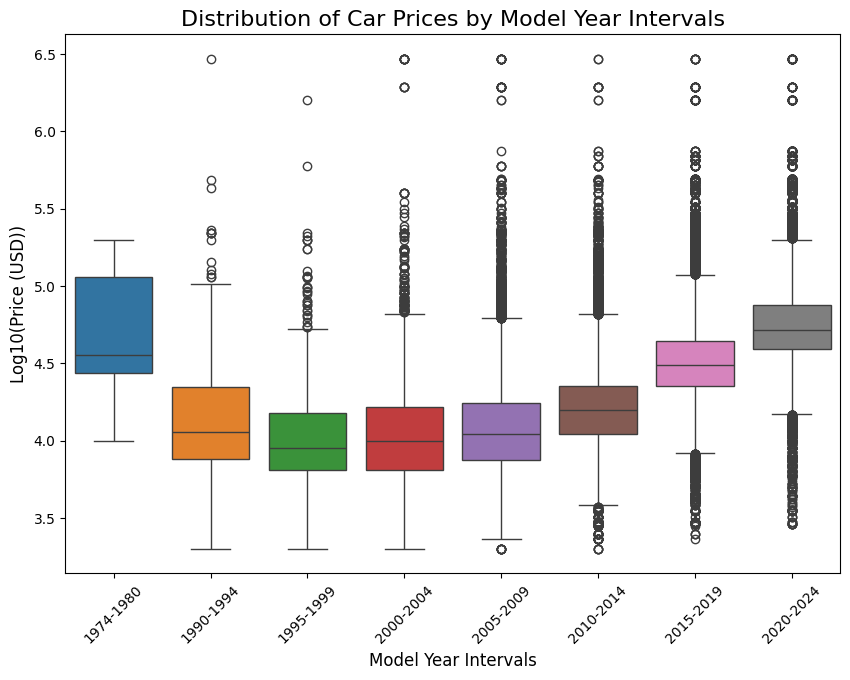

In [ ]:
# Define the intervals
bins = [1973, 1980, 1994, 1999, 2004, 2009, 2014, 2019, 2024] 
labels = ["1973-1979", "1990-1994", "1995-1999", "2000-2004", "2005-2009", 
          "2010-2014", "2015-2019", "2020-2024"]

# Add an interval column
df_interval = df_preprocessed.copy()
df_interval['year_interval'] = pd.cut(df_interval['model_year'], bins=bins, labels=labels, right=True)

prices_log = np.log10(df_interval['price'])

# Create a box plot
plt.figure(figsize=(10, 7))
sns.boxplot(x='year_interval', y=prices_log, data=df_interval, hue='year_interval', legend=False)

# Add titles and labels
plt.title('Distribution of Car Prices by Model Year Intervals', fontsize=16)
plt.xlabel('Model Year Intervals', fontsize=12)
plt.ylabel('Log 10 (Price (in USD))', fontsize=12)
plt.xticks(rotation=45)
plt.show()